## 1. Importing Libraries

In [1]:
#pip install -U --trusted-host files.pythonhosted.org --trusted-host pypi.org --trusted-host pypi.python.org matplotlib
#pip install -U --trusted-host files.pythonhosted.org --trusted-host pypi.org --trusted-host pypi.python.org seaborn 
#pip install -U --trusted-host files.pythonhosted.org --trusted-host pypi.org --trusted-host pypi.python.org plotly
#pip install -U --trusted-host files.pythonhosted.org --trusted-host pypi.org --trusted-host pypi.python.org statsmodels
#pip install -U --trusted-host files.pythonhosted.org --trusted-host pypi.org --trusted-host pypi.python.org pmdarima
#pip install -U --trusted-host files.pythonhosted.org --trusted-host pypi.org --trusted-host pypi.python.org holidays

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from math import sqrt

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error,mean_squared_error

from pandas.tseries.holiday import get_calendar, HolidayCalendarFactory, GoodFriday
from datetime import date

from sklearn.preprocessing import MinMaxScaler
import holidays
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

## 2. Data Understanding

In the Data Understanding section, I have conducted an in-depth exploration of the datasets to gain valuable insights into sales and customer behavior. I began by loading and examining the core datasets, which include transactional data and store-specific attributes. To enhance the analysis, I engineered new features such as Year, Month, and Day from the Date index and computed SalePerCustomer to understand average sales per customer. These features allow for a more detailed temporal and performance analysis. I then utilized ECDF (Empirical Cumulative Distribution Function) plots to visualize the distribution of sales, customer counts, and sales per customer, providing a cumulative view of data distribution and highlighting trends and outliers. Additionally, I performed time series analysis and visualized sales trends over time, along with analyzing sales distribution by day of the week, year, store type, and promotion status. This comprehensive data understanding is crucial for identifying patterns, trends, and anomalies, guiding further analysis, and making informed decisions based on the data.

In [2]:
def load_data(file_path):
    """
    Load the time series data from a CSV file.

    Parameters:
    file_path (str): Path to the CSV file.

    Returns:
    pd.DataFrame: Loaded data as a pandas DataFrame.
    """
    return pd.read_csv(file_path)

In [3]:
data_path = 'data.csv'
df = load_data(data_path)
#df.set_index('Date',inplace=True)

store_path='store.csv'
store=load_data(store_path)

In [4]:
def add_date_features(df, datecolumn):
    """
    Adds year, month, and day as separate columns to the DataFrame based on the specified date column.

    Args:
    df (pd.DataFrame): The input DataFrame.
    datecolumn (str): The name of the column containing date values.

    Returns:
    pd.DataFrame: DataFrame with new date features.
    """
    df[datecolumn] = pd.to_datetime(df[datecolumn])
    df['Year'] = df[datecolumn].dt.year
    df['Month'] = df[datecolumn].dt.month
    df['Day'] = df[datecolumn].dt.day
    return df

In [5]:
add_date_features(df,'Date')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7,31
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7,31
...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,2013,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,2013,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,2013,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,2013,1,1


In [6]:
def plot_ecdf(data, column, xlabel):
    """
    Plot the Empirical Cumulative Distribution Function (ECDF) for a given column in the DataFrame.

    Parameters:
    data (pd.DataFrame): DataFrame containing the data.
    column (str): Column name for which to plot the ECDF.
    xlabel (str): Label for the x-axis.
    color (str): Color of the plot.

    Returns:
    None
    """
    plt.figure(figsize=(8, 4))
    cdf = ECDF(data[column])
    plt.plot(cdf.x, cdf.y, label="statmodels", color='#386B7F')
    plt.xlabel(xlabel)
    plt.title(f'ECDF of {xlabel}')
    plt.show()

#### Sales ECDF Plot:This plot shows the cumulative distribution of sales values. It allows you to see how sales values are distributed and how the proportion of data increases as the sales values increase.

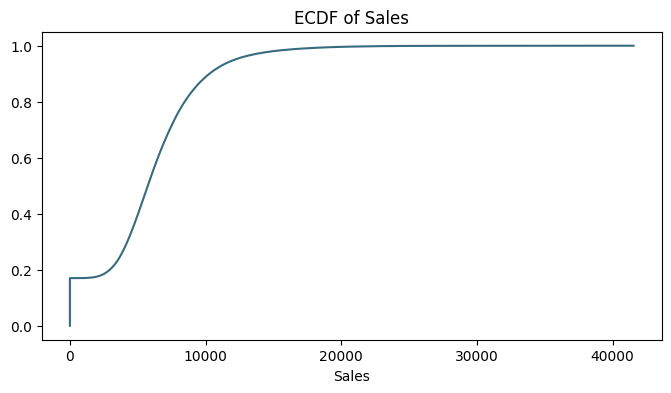

In [7]:
 plot_ecdf(df, 'Sales', 'Sales')

#### Customers ECDF Plot:This plot illustrates the cumulative distribution of the number of customers. It helps in understanding how customer counts are distributed across different values.

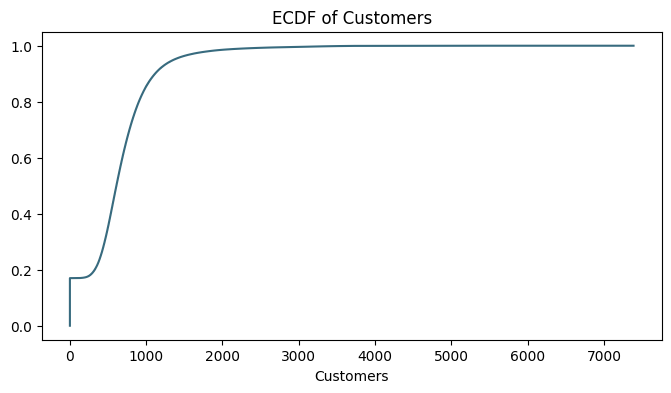

In [8]:
plot_ecdf(df, 'Customers', 'Customers')

### Sales distributions over time

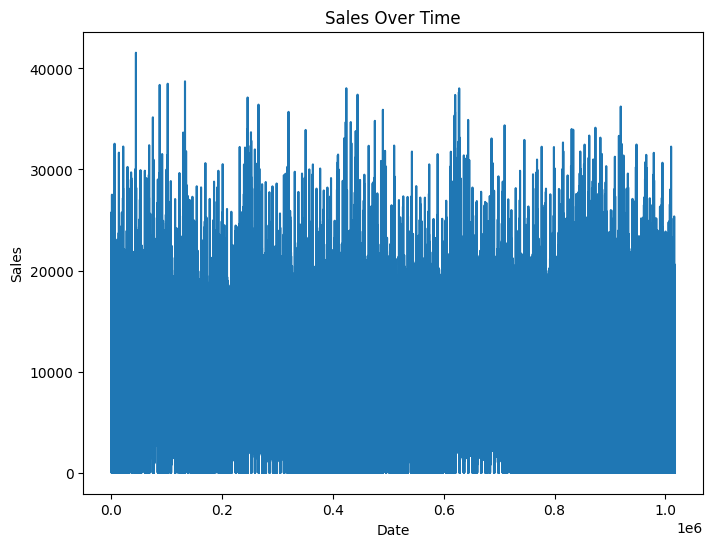

In [9]:
# Sales distribution over time
plt.figure(figsize=(8, 6))
df['Sales'].plot()
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()



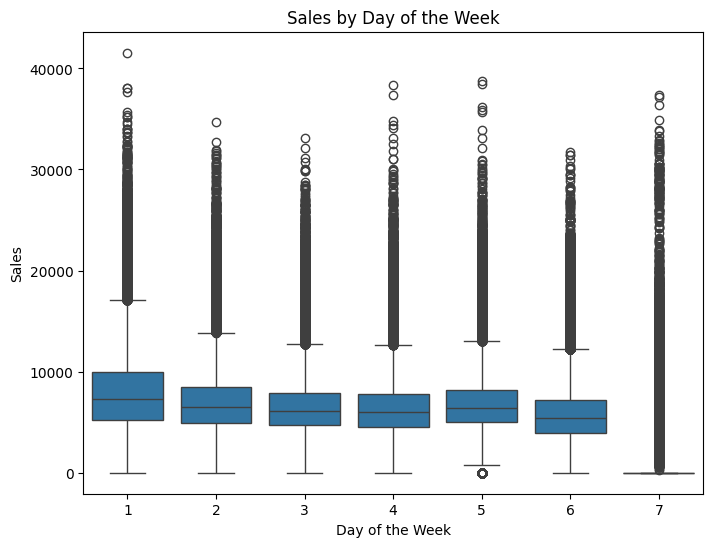

In [10]:
# Sales distribution by day of the week
plt.figure(figsize=(8,6))
sns.boxplot(x='DayOfWeek', y='Sales', data=df)
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.show()



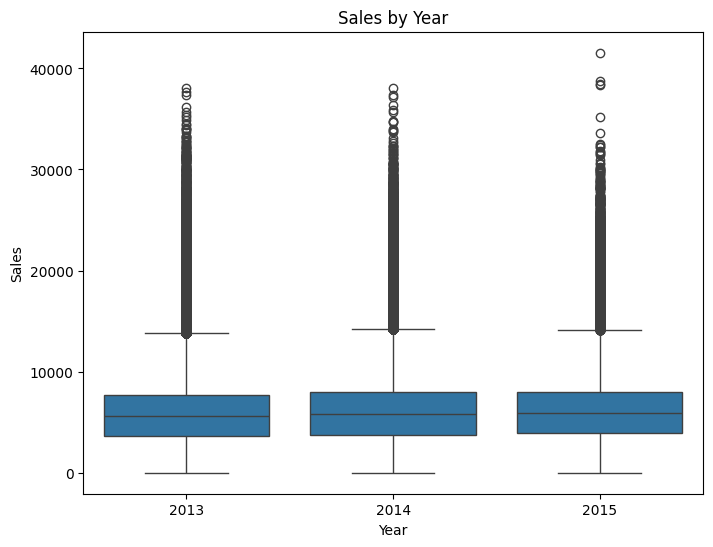

In [11]:
# Sales distribution by year
plt.figure(figsize=(8,6))
sns.boxplot(x='Year', y='Sales', data=df)
plt.title('Sales by Year')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()


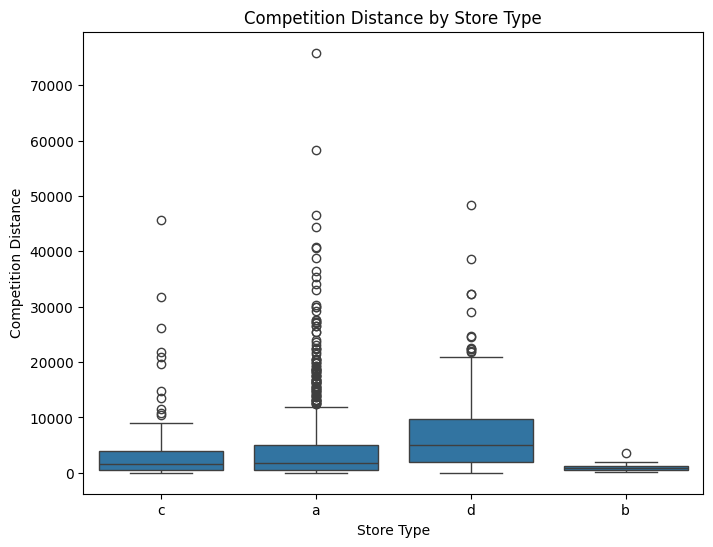

In [12]:
# Competition distance by store type
plt.figure(figsize=(8,6))
sns.boxplot(x='StoreType', y='CompetitionDistance', data=store)
plt.title('Competition Distance by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Competition Distance')
plt.show()


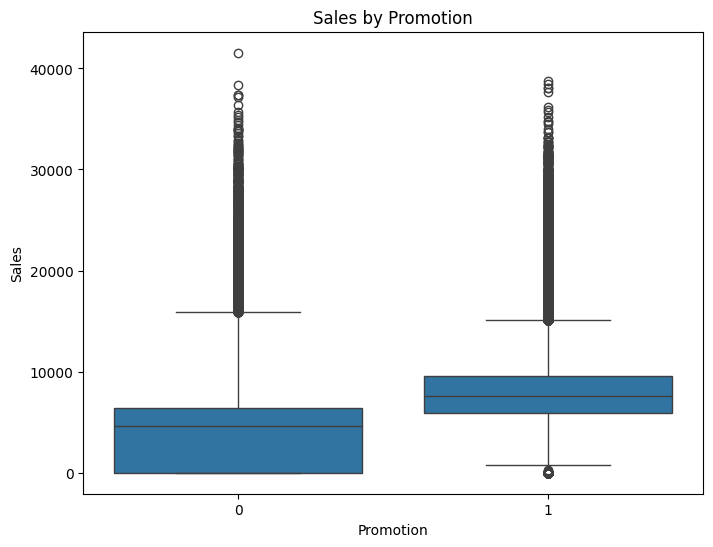

In [13]:
# Effect of promotions
plt.figure(figsize=(8,6))
sns.boxplot(x='Promo', y='Sales', data=df)
plt.title('Sales by Promotion')
plt.xlabel('Promotion')
plt.ylabel('Sales')
plt.show()

## 3. Data Preparation 

In the Data Preparation section, I performed several critical steps to ensure the data is clean, complete, and suitable for analysis. I filtered out rows with zero values to exclude days with no sales or store closures, addressed missing values by filling them with median or zero values to maintain dataset integrity, and merged the sales and store datasets to combine relevant information. I tested the stationarity of the time series data using visual and statistical methods, which is crucial for applying time series models. Additionally, I analyzed the autocorrelation and partial autocorrelation of the sales data to identify temporal patterns and dependencies. These preparation steps are essential for creating a robust foundation for further analysis and modeling, ensuring accurate and meaningful insights.

 #### Filtering Out Zero Values:

This step removes rows where the Open column is zero or Sales is zero. These rows might represent days when the store was closed or had no sales, which could skew the analysis. By filtering these out, we ensure that the dataset only includes days with valid sales data.

In [14]:
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

#### Handling Missing Values:

Missing values in the CompetitionDistance column of the store dataset are filled with the median value to preserve the distribution of the data. All other missing values are filled with zeros. This approach prevents issues during analysis and ensures that the datasets are complete and usable.


In [15]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)
store.fillna(0, inplace=True)

#### Data Merging:


 The df and store datasets are merged on the Store column using an inner join. This combines the sales data with store-specific attributes, providing a comprehensive dataset that includes both sales figures and store characteristics for further analysis.

In [16]:
df_merged = pd.merge(df, store, on='Store', how='inner')
df_merged

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015,...,30,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,2015,...,29,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,2015,...,28,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,2015,...,27,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,292,1,2013-01-07,9291,1002,1,1,0,0,2013,...,7,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844334,292,6,2013-01-05,2748,340,1,0,0,0,2013,...,5,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844335,292,5,2013-01-04,4202,560,1,0,0,1,2013,...,4,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844336,292,4,2013-01-03,4580,662,1,0,0,1,2013,...,3,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0


#### Testing for Stationarity:

This function tests the stationarity of a time series, which is crucial for time series modeling. It plots the rolling mean and standard deviation to visually inspect stationarity and uses the Augmented Dickey-Fuller (ADF) test to provide a statistical test for stationarity. Testing for stationarity is essential for ensuring that the time series data meets the assumptions of many forecasting models.

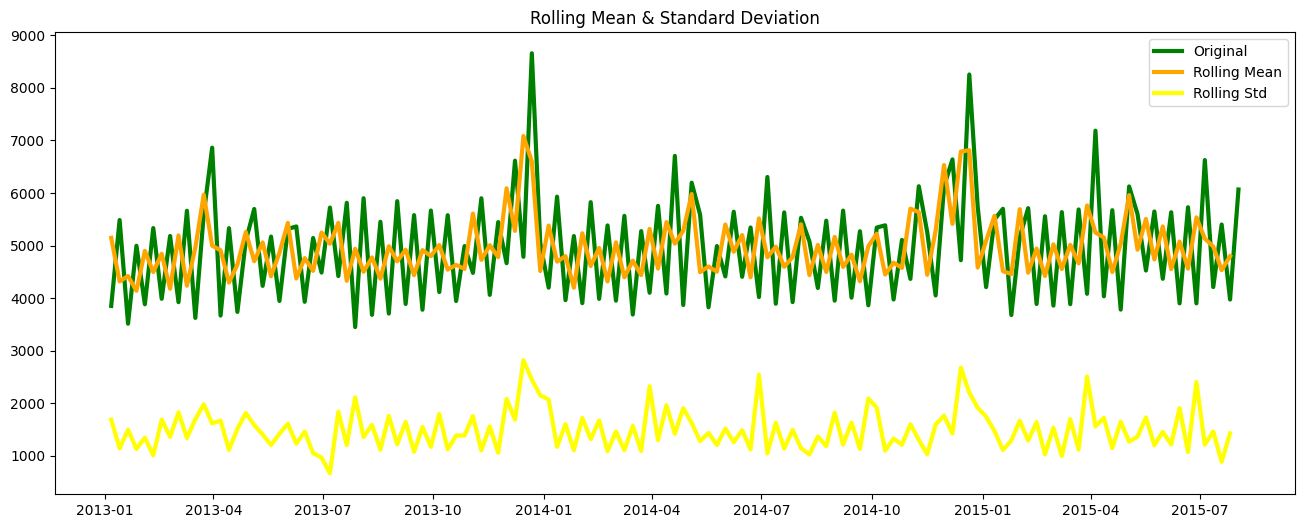

ADF Statistics: -5.292708
P-value: 0.000006
Critical Value (1%): -3.439
Critical Value (5%): -2.865
Critical Value (10%): -2.569


In [17]:
def test_stationarity(timeseries):
    """
    Test the stationarity of a time series using rolling statistics and the Augmented Dickey-Fuller test.

    This function plots the original time series along with its rolling mean and standard deviation.
    It also performs the Augmented Dickey-Fuller test to provide statistical evidence of stationarity.

    Parameters:
    timeseries (pd.Series): Time series data to be tested for stationarity.

    Returns:
    None
    """
    # Calculate rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
    
    # Plot original series and rolling statistics
    plt.subplots(figsize=(16, 6))
    plt.plot(timeseries.resample('W').mean(), color='green', linewidth=3, label='Original')
    plt.plot(roll_mean.resample('W').mean(), color='orange', linewidth=3, label='Rolling Mean')
    plt.plot(roll_std.resample('W').mean(), color='yellow', linewidth=3, label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Perform Augmented Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistics: %f' % result[0])
    print('P-value: %f' % result[1])
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value:.3f}')

# Testing for one store group
df.set_index('Date',inplace=True)
sales_a = df[df.Store == 2]['Sales']
test_stationarity(sales_a)



#### Autocorrelation and Partial Autocorrelation Analysis:


 This function computes and plots the autocorrelation function (ACF) and partial autocorrelation function (PACF) of the sales data. These plots are used to identify the correlation between observations at different lags and help in selecting appropriate parameters for time series models like ARIMA. They are essential for understanding the underlying patterns and dependencies in the time series data

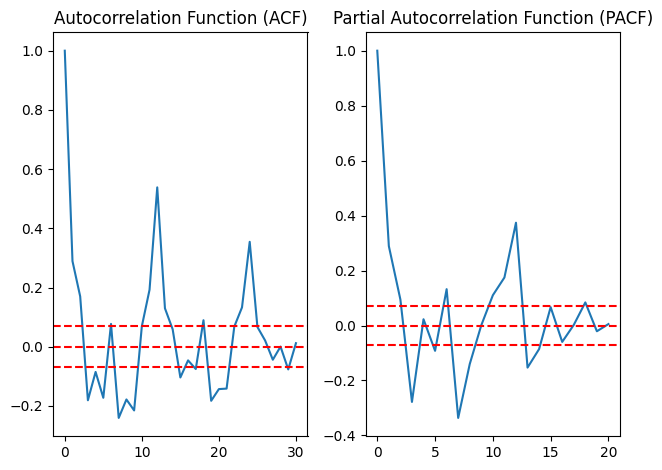

In [18]:
# Autocorrelation and Partial Autocorrelation Analysis
def auto_corr(sales):
    """
    Perform Autocorrelation and Partial Autocorrelation analysis on a time series.

    This function calculates the autocorrelation function (ACF) and partial autocorrelation function (PACF)
    for a given time series and plots the results.

    Parameters:
    sales (pd.Series): Time series data to be analyzed.

    Returns:
    None
    """
    lag_acf = acf(sales, nlags=30)
    lag_pacf = pacf(sales, nlags=20, method='ols')
    
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.title('Autocorrelation Function (ACF)')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle='--', color='red')
    plt.title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()
auto_corr(sales_a)


## 4. Modelling 

In the Modelling step, I focused on developing forecasting models to predict future sales using historical data. I first prepared the data by resampling it to a weekly frequency to smooth out daily fluctuations. Next, I employed the auto_arima function to determine the optimal parameters for the ARIMA model, which captures non-seasonal patterns in the time series. Following this, I fitted the ARIMA model to the data. Additionally, I built a SARIMA model, which accounts for both non-seasonal and seasonal effects, providing a more accurate forecasting approach for data with periodic patterns. These models are essential for generating reliable sales forecasts and understanding underlying trends and seasonality in the data.

#### Preparing the Data for ARIMA and SARIMA

In [19]:
df_model = df[['Sales']].copy()
df_model = df_model.resample('w').mean()

#### Fitting the ARIMA Model:

The auto_arima function is used to identify the best ARIMA model parameters (order) and seasonal parameters (seasonal_order) for the given time series. It automatically selects the best model based on criteria such as AIC (Akaike Information Criterion). After determining the optimal parameters, an ARIMA model is fit to the data using these parameters. The ARIMA model helps in capturing non-seasonal patterns in the time series data.

In [20]:
model = auto_arima(df_model, seasonal=True, m=12, suppress_warnings=True)
print("ARIMA Order:", model.order)
print("Seasonal Order:", model.seasonal_order)

ARIMA Order: (4, 1, 1)
Seasonal Order: (0, 0, 1, 12)


In [21]:
model_arima = ARIMA(df_model, order=model.order)
results_arima = model_arima.fit()


#### Fitting the SARIMA Model:

he SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) model is then fitted to the data using both non-seasonal and seasonal parameters. The SARIMA model extends ARIMA by incorporating seasonal effects, which is useful when the data exhibits periodic patterns or seasonality. This model provides a more comprehensive approach to forecasting by accounting for both non-seasonal and seasonal components.

In [22]:
model_sarima = SARIMAX(df_model, order=model.order, seasonal_order=model.seasonal_order)
results_sarima = model_sarima.fit()

## 5. Model Evaluations

In the Model Evaluation step, the performance of the ARIMA and SARIMA models was assessed by generating predictions for a specified period and comparing them against the actual sales data. Predictions were made starting from January 4, 2015, and forecasted values were compared with the true sales values. The evaluation utilized three error metrics: RMSE, MAE, and MAPE, to measure the accuracy of the forecasts. RMSE provides an overall measure of forecast error magnitude, MAE indicates the average error in absolute terms, and MAPE expresses the percentage of error relative to actual values. This evaluation is crucial for understanding the effectiveness of each model and guiding the choice of the best forecasting approach based on their performance.

#### Generating Predictions:

Predictions are generated for the period starting from January 4, 2015, for both the ARIMA and SARIMA models. The get_prediction method is used to obtain the forecasted values, and predicted_mean extracts the forecasted sales. The actual sales data for the same period is also retrieved for comparison.

In [23]:
pred_arima = results_arima.get_prediction(start=pd.to_datetime('2015-1-4'), dynamic=False)
train_arima_forecasted = pred_arima.predicted_mean
train_arima_truth = df_model['2015-01-04':]

pred_sarima = results_sarima.get_prediction(start=pd.to_datetime('2015-1-4'), dynamic=False)
train_sarima_forecasted = pred_sarima.predicted_mean
train_sarima_truth = df_model['2015-01-04':]

#### Evaluating Model Performance:

In [24]:
def calculate_errors(y_true, y_pred):
    """
    Calculate common regression error metrics: RMSE, MAE, and MAPE.

    This function calculates the Root Mean Squared Error (RMSE), Mean Absolute Error (MAE),
    and Mean Absolute Percentage Error (MAPE) between the true and predicted values.

    Parameters:
    y_true (array-like): True values.
    y_pred (array-like): Predicted values.

    Returns:
    tuple: A tuple containing RMSE, MAE, and MAPE.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape


In [25]:
stat_df = pd.DataFrame(index=['ARIMA', 'SARIMA'], columns=['RMSE', 'MAE', 'MAPE'])

for model in ['ARIMA', 'SARIMA']:
    y_true = df_model['2015-01-04':]['Sales']
    y_pred = train_arima_forecasted if model == 'ARIMA' else train_sarima_forecasted
    rmse, mae, mape = calculate_errors(y_true, y_pred)
    stat_df.loc[model] = [rmse, mae, mape]
    
stat_df

,RMSE,MAE,MAPE
ARIMA,933.059988,721.850721,10.510211
SARIMA,909.10972,722.735811,10.382784


## 6. Result Visualization

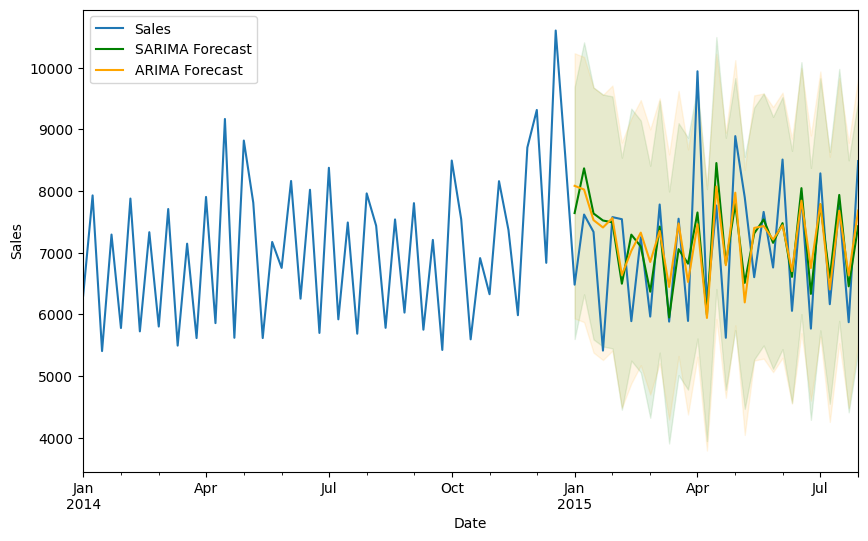

In [27]:
ax = df_model['2014':].plot(label='Observed', figsize=(10, 6))
pred_sarima.predicted_mean.plot(ax=ax, label='SARIMA Forecast', alpha=1, color='green')
ax.fill_between(pred_sarima.conf_int().index, pred_sarima.conf_int().iloc[:, 0], pred_sarima.conf_int().iloc[:, 1], color='green', alpha=.1)
pred_arima.predicted_mean.plot(ax=ax, label='ARIMA Forecast', alpha=1, color='orange')
ax.fill_between(pred_arima.conf_int().index, pred_arima.conf_int().iloc[:, 0], pred_arima.conf_int().iloc[:, 1], color='orange', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [28]:
print("Model Performence Metrics:")
print(stat_df)


Model Performence Metrics:
              RMSE         MAE       MAPE
ARIMA   933.059988  721.850721  10.510211
SARIMA   909.10972  722.735811  10.382784


In [29]:
forecast_df = pd.DataFrame({'ARIMA Forecast': train_arima_forecasted, 'SARIMA Forecast': train_sarima_forecasted, 'Observed': train_sarima_truth['Sales']})
forecast_df


,ARIMA Forecast,SARIMA Forecast,Observed
Date,,,
2015-01-04,8084.720474,7642.819661,6481.154089
2015-01-11,8024.976117,8368.748062,7619.166380
2015-01-18,7528.911847,7636.376967,7337.628746
2015-01-25,7409.314683,7522.299976,5411.591404
2015-02-01,7561.052005,7491.713110,7577.343330
2015-02-08,6637.177230,6496.456206,7543.427399
2015-02-15,7030.034813,7292.725150,5889.046071
2015-02-22,7325.595555,7100.743580,7249.448364
2015-03-01,6849.585853,6366.828278,5963.368673
